# Import necessary libraries and set parameters

In [1]:
# Import necessary libraries
import numpy as np
import theano
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans  # Import KMeans clustering algorithm
import warnings
import matplotlib as mpl

# Set plotting parameters
mpl.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams.update({
    'axes.spines.bottom': True,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False
})


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\65747\miniconda3\envs\M845\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Define the true value function of the task space

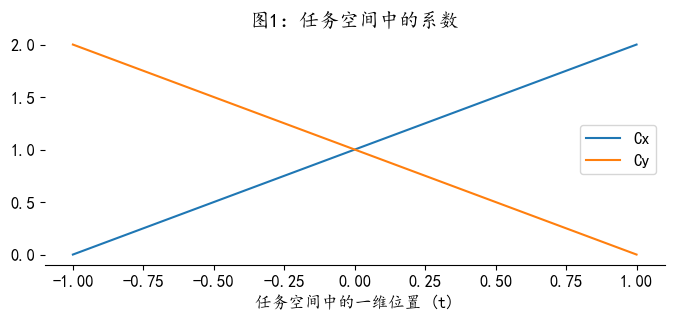

In [2]:
def measure_task(t):
    """
    Define the "true value" function of the task space
    """
    Cx = t + 1
    Cy = -t + 1
    b = 0
    return Cx, Cy, b

tt = np.linspace(-1, 1, 100)
Cx, Cy, b = measure_task(tt)

plt.figure(figsize=(8, 3))
plt.plot(tt, Cx, label="Cx")
plt.plot(tt, Cy, label="Cy")
plt.xlabel("One-dimensional position in the task space (t)")
plt.legend()
plt.title("Figure 1: Coefficients in the task space")
plt.show()


# Define measurement function and variable feature generation function

In [3]:
def ground_truth(features, t):
    """
    Define the world model we are trying to measure at a given point 't' in the task space
    """
    Cx_t, Cy_t, b = measure_task(t)
    z = Cx_t * features[:, 0] + Cy_t * features[:, 1] + b
    return z

def measure(features, t):
    """
    Perform an experiment at a given point 't' in the task space with features and return the result with measurement noise
    """
    sigma = .5  
    z_measured = ground_truth(features, t) + np.random.normal(loc=0, scale=sigma, size=features.shape[0])
    return z_measured

def generate_random_data(n_samples, n_features):
    """
    Generate random feature data
    """
    return np.random.uniform(-1, 1, size=(n_samples, n_features))

measure(generate_random_data(1, 2), t=1)


array([1.17034427])

# Plot the "true value" in the task space

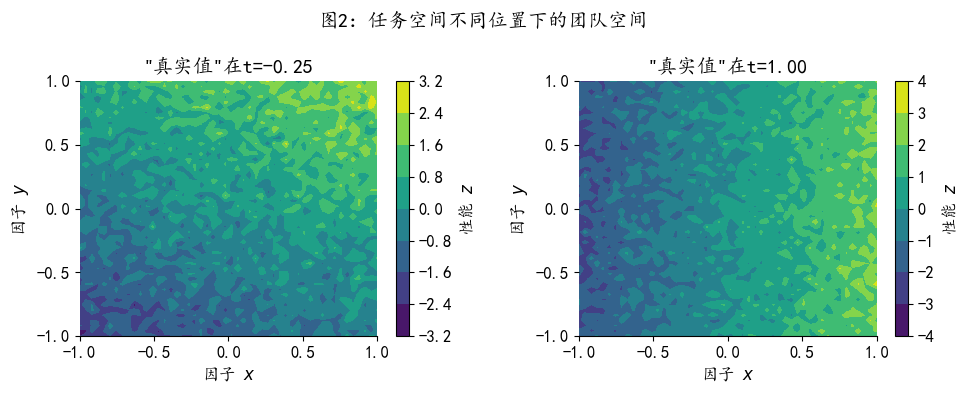

In [4]:
xx, yy = np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50))
features = np.c_[xx.ravel(), yy.ravel()]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
t = -.25
zz_observations = measure(features, t).reshape(xx.shape)
plt.contourf(xx, yy, zz_observations)
plt.xlabel("Factor $x$")
plt.ylabel("Factor $y$")
plt.colorbar(label="Performance $z$")
plt.title('"True Value" at t=%.02f' % t)

plt.subplot(1, 2, 2)
t = 1
zz_observations = measure(features, t).reshape(xx.shape)
plt.contourf(xx, yy, zz_observations)
plt.xlabel("Factor $x$")
plt.ylabel("Factor $y$")
plt.colorbar(label="Performance $z$")
plt.title('"True Value" at t=%.02f' % t)

plt.suptitle("Figure 2: Team Space at Different Positions in the Task Space")
plt.tight_layout()
plt.show()


# Construct the hierarchical model of the task space

In [5]:
def build_model(features, t_sampled, z_observations, gp_length_scale=.4):
    """
    Construct MCMC model components, representing our understanding of the data generation process
    """
    n_samples, n_features = features.shape
    with pm.Model() as taskspace_hierarchical_model:
        # Define Gaussian processes to represent each coefficient
        # The mean function defaults to 0
        cov_func = pm.gp.cov.ExpQuad(1, ls=gp_length_scale)
        gp = [pm.gp.Latent(cov_func=cov_func) for _ in range(n_features)]
        
        # Place a GP prior on each coefficient in the task space dimensions
        C = [gp[i].prior(f"C_{i}", X=t_sampled[:, None]) for i in range(n_features)]
        
        # Constant prior for the intercept
        b = pm.Normal("b", mu=0, sd=1)
        
        # Prior for noise
        noise = pm.Gamma("noise", alpha=2, beta=1)
        
        # Assume a linear function form in the team space
        z = pm.Deterministic("z", sum(C[i] * features[:, i] for i in range(n_features)) + b)
        
        # Assume observations come with Gaussian noise
        z_measured = pm.Normal("z_measured", mu=z, sd=noise, observed=z_observations)
        
    return taskspace_hierarchical_model, gp


# Fit the model and plot the task space

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, b, C_1_rotated_, C_0_rotated_]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████████| 6000/6000 [07:43<00:00, 12.95draws/s]
C:\Users\65747\miniconda3\envs\M845\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 49.42it/s]


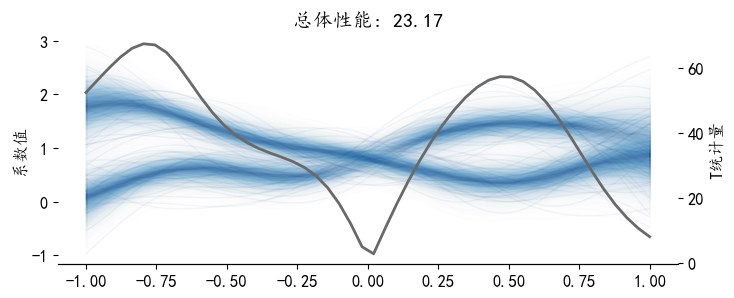

In [6]:
def draw_task_space(taskspace_hierarchical_model, gp, trace, ax, plot_t=np.linspace(-1, 1, 50)):
    """
    Plot the model results in the task space
    """
    n_features = len(gp)
    
    with taskspace_hierarchical_model:
        C_plot = [gp[i].conditional(f"C_plot_{i}", plot_t[:, None]) for i in range(n_features)]
        C_functions = pm.sample_posterior_predictive(trace, var_names=[f"C_plot_{i}" for i in range(n_features)], samples=500)
    
    for i in range(n_features):
        plot_gp_dist(ax, C_functions[f"C_plot_{i}"], plot_t, palette="Blues", fill_alpha=.05, samples_alpha=.05)
        ax.plot([], [], 'cornflowerblue', alpha=1, linewidth=2, label=f"C_{i}")
    
    ax.set_ylabel("Coefficient Value")
    t_statistics = np.array([np.abs(ttest_ind(C_functions[f'C_plot_{i}'][:, j], C_functions[f'C_plot_{(i+1)%n_features}'][:, j]).statistic) for j in range(len(plot_t))])
    
    ax2 = ax.twinx()
    ax2.plot(plot_t, t_statistics, 'dimgrey', linewidth=2)
    ax2.set_ylabel("T Statistic")
    ax.plot([], [], 'dimgrey', linewidth=2, label="T Statistic")
    
    performance = 1 / np.mean(1 / t_statistics)
    ax.set_title("Overall Performance: %.02f" % performance)
    
    plt.xlabel("One-dimensional Position in the Task Space")
    return C_functions

n_samples = 60
n_features = 2
features = generate_random_data(n_samples, n_features)
t_sampled = np.random.uniform(-1, 1, size=n_samples)
z_observations = measure(features, t_sampled)

taskspace_hierarchical_model, gp = build_model(features, t_sampled, z_observations)
pm.model_to_graphviz(taskspace_hierarchical_model)

with taskspace_hierarchical_model:
    trace = pm.sample(1000)

plt.figure(figsize=(8, 3))
ax = plt.subplot(1, 1, 1)
C_functions = draw_task_space(taskspace_hierarchical_model, gp, trace, ax=ax)
plt.show()


# Define the acquisition function

In [7]:
def select_max_variance(taskspace_hierarchical_model, trace, candidate_features, candidate_t, gp):
    n_features = len(gp)
    with taskspace_hierarchical_model:
        C_candidates = [gp[i].conditional(f"C_candidates_{i}", candidate_t[:, None]) for i in range(n_features)]
        performance_pred = pm.Deterministic("performance_pred", sum(C_candidates[i] * candidate_features[:, i] for i in range(n_features)) + trace["b"])
        predictions = pm.sample_posterior_predictive(trace, var_names=["performance_pred"], samples=500)
    
    score = predictions['performance_pred'].var(axis=0)
    choice_index = np.argmax(score)
    return candidate_features[choice_index], candidate_t[choice_index]

# Active learning loop

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, b, C_1_rotated_, C_0_rotated_]
Sampling 4 chains, 10 divergences: 100%|██████████████████████████████████████| 8000/8000 [02:55<00:00, 45.55draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
C:\Users\65747\miniconda3\envs\M845\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████████████████████████████████████████████████████████████████

ValueError: Not enough samples to build a trace.

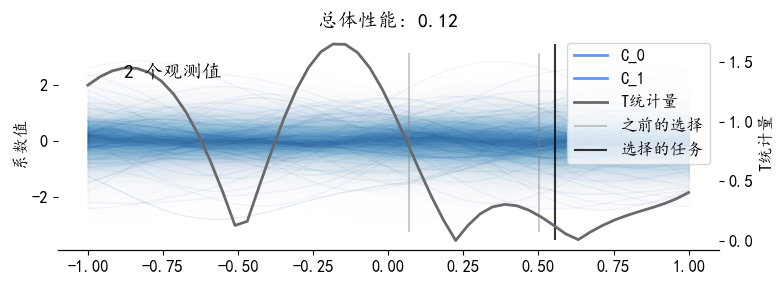

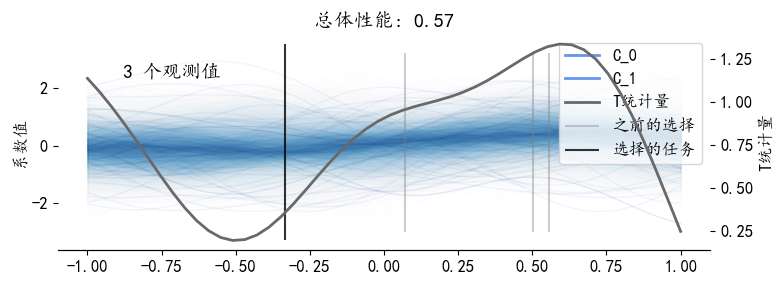

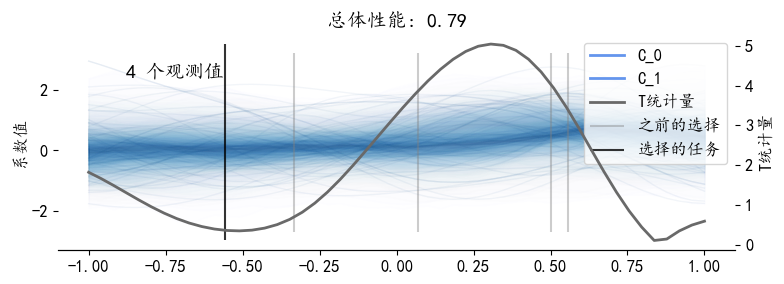

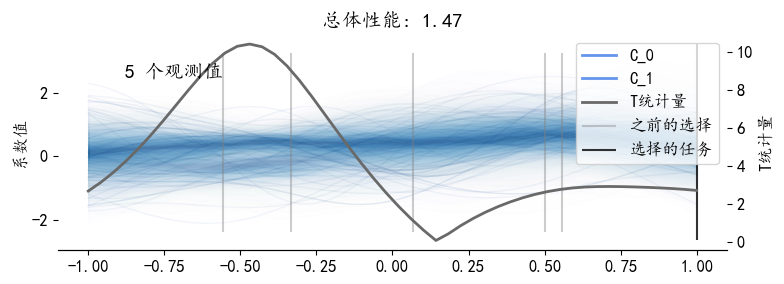

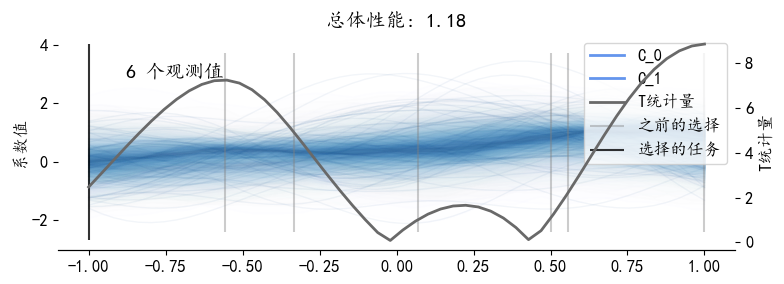

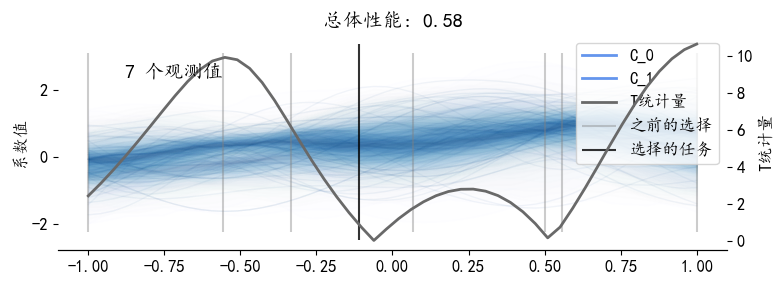

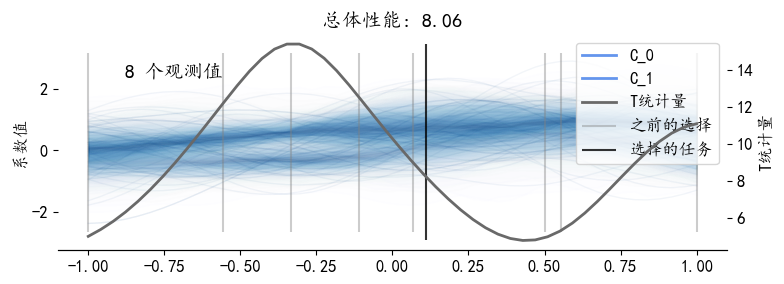

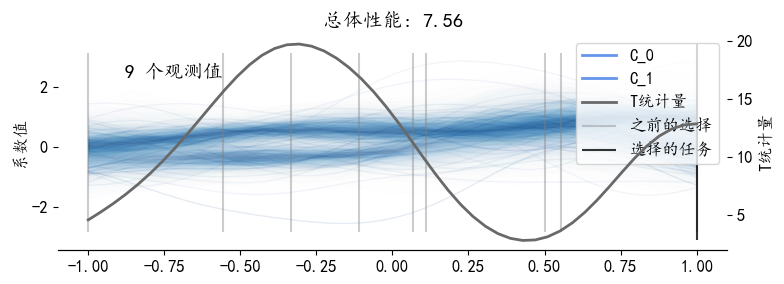

In [8]:
import numpy as np
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

def generate_random_data(n_samples, n_features):
    return np.random.uniform(-1, 1, size=(n_samples, n_features))

def measure(features, t):
    C = t[:, None] + np.arange(features.shape[1])
    b = 0
    z_measured = np.dot(features, C.T).sum(axis=1) + b + np.random.normal(loc=0, scale=0.5, size=features.shape[0])
    return z_measured

def build_model(features, t_sampled, z_observations, gp_length_scale=0.4):
    n_samples, n_features = features.shape
    with pm.Model() as model:
        cov_func = pm.gp.cov.ExpQuad(1, ls=gp_length_scale)
        gp = [pm.gp.Latent(cov_func=cov_func) for _ in range(n_features)]
        
        C = [gp[i].prior(f"C_{i}", X=t_sampled[:, None]) for i in range(n_features)]
        
        b = pm.Normal("b", mu=0, sd=10)
        noise = pm.Gamma("noise", alpha=2, beta=1)
        
        z = sum(C[i] * features[:, i] for i in range(n_features)) + b
        z = pm.Deterministic("z", z)
        
        z_measured = pm.Normal("z_measured", mu=z, sd=noise, observed=z_observations)
        
    return model, gp

def draw_task_space(model, gp, trace, ax, plot_t=np.linspace(-1, 1, 50)):
    n_features = len(gp)
    
    with model:
        C_plot = [gp[i].conditional(f"C_plot_{i}", plot_t[:, None]) for i in range(n_features)]
        C_functions = pm.sample_posterior_predictive(trace, var_names=[f"C_plot_{i}" for i in range(n_features)], samples=200)
    
    for i in range(n_features):
        plot_gp_dist(ax, C_functions[f"C_plot_{i}"], plot_t, palette="Blues", fill_alpha=.05, samples_alpha=.05)
        ax.plot([], [], 'cornflowerblue', alpha=1, linewidth=2, label=f"C_{i}")
    
    ax.set_ylabel("Coefficient Value")
    t_statistics = np.array([np.abs(ttest_ind(C_functions[f'C_plot_{i}'], C_functions[f'C_plot_{(i+1)%n_features}']).statistic) for i in range(n_features)])
    t_statistics = t_statistics.mean(axis=0)  # Average statistic to match positions in task space
    
    ax2 = ax.twinx()
    ax2.plot(plot_t, t_statistics, 'dimgrey', linewidth=2)
    ax2.set_ylabel("T Statistic")
    ax.plot([], [], 'dimgrey', linewidth=2, label="T Statistic")
    
    performance = 1 / np.mean(1 / t_statistics)
    ax.set_title("Overall Performance: %.02f" % performance)
    
    plt.xlabel("One-dimensional Position in the Task Space")
    return C_functions

def select_max_variance(model, trace, candidate_features, candidate_t, gp):
    n_features = len(gp)
    with model:
        # Define posterior predictive for candidate sample points
        C_candidates = [gp[i].conditional(f"C_candidates_{i}", candidate_t[:, None]) for i in range(n_features)]
        
        # Predict performance in team space given coefficients sampled at positions in task space
        performance_pred = pm.Deterministic(
            "performance_pred",
            sum(C_candidates[i] * candidate_features[:, i][:, None].T for i in range(n_features)) + trace["b"][:, None]
        )
        
        predictions = pm.sample_posterior_predictive(trace, var_names=["performance_pred"], samples=200)
    
    # Compute the score (variance) for each candidate sample point
    score = predictions['performance_pred'].var(axis=0)
    
    # Find the index of the candidate point with the highest variance
    choice_index = np.argmax(score)
    
    # Ensure the index is within a valid range
    choice_index = choice_index % candidate_features.shape[0]
    
    return candidate_features[choice_index, 0], candidate_features[choice_index, 1], candidate_t[choice_index]

# Active learning loop
n_initial_samples = 2
n_features = 2

# Generate initial sample data
initial_features = generate_random_data(n_initial_samples, n_features)
xs = initial_features[:, 0]
ys = initial_features[:, 1]
ts = np.random.uniform(-1, 1, size=n_initial_samples)
z_observations = measure(initial_features, ts)

candidate_xs, candidate_ys, candidate_ts = np.meshgrid(
    np.linspace(-1, 1, 2),
    np.linspace(-1, 1, 2),
    np.linspace(-1, 1, 10),
)

n_iterations = 10
for i in range(n_iterations):
    
    # Fit the surrogate model
    features = np.c_[xs, ys]
    taskspace_hierarchical_model, gp = build_model(features, ts, z_observations)
    with taskspace_hierarchical_model:
        trace = pm.sample(1000, tune=1000, target_accept=0.98)  # Increase target_accept parameter
        
    # Predict results for candidate points and select the best point
    candidate_features = np.c_[candidate_xs.flatten(), candidate_ys.flatten()]
    selection = select_max_variance(taskspace_hierarchical_model, trace, candidate_features, candidate_ts.flatten(), gp)
    
    # Perform the next sample measurement
    next_observation = measure(np.array([[selection[0], selection[1]]]), np.array([selection[2]]))
    
    # Plot current state of knowledge and the next decision
    plt.figure(figsize=(8, 3))
    ax = plt.subplot(1, 1, 1)
    C_functions = draw_task_space(taskspace_hierarchical_model, gp, trace, ax=ax)
    ax.vlines(ts, *ax.get_ylim(), color='grey', label="Previous Choices", alpha=.4)
    ax.vlines(selection[2], *ax.get_ylim(), color='k', label='Selected Task', alpha=.8)
    plt.tight_layout()
    plt.annotate("%i Observations" % len(z_observations), xy=(.1, .8), xycoords='axes fraction', fontsize=14)
    ax.legend(loc="upper right")
    
    # Add new sample to the dataset
    xs = np.append(xs, selection[0])
    ys = np.append(ys, selection[1])
    ts = np.append(ts, selection[2])
    z_observations = np.append(z_observations, next_observation)


# Clustering experiments

In [ ]:
n_samples = 60
n_features = 3
features = generate_random_data(n_samples, n_features)
t_sampled = np.random.uniform(-1, 1, size=n_samples)
z_observations = measure(features, t_sampled)

# Clustering experiments
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(features)

for cluster in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster)
    cluster_features = features[cluster_indices]
    cluster_t_sampled = t_sampled[cluster_indices]
    cluster_z_observations = z_observations[cluster_indices]
    
    taskspace_hierarchical_model, gp = build_model(cluster_features, cluster_t_sampled, cluster_z_observations)
    with taskspace_hierarchical_model:
        trace = pm.sample(1000)
    
    fig, ax = plt.subplots(figsize=(8, 3))
    draw_task_space(taskspace_hierarchical_model, gp, trace, ax=ax)
    plt.title(f"Cluster {cluster}")
    plt.show()
